# <center> Basic CNN architecture <center>

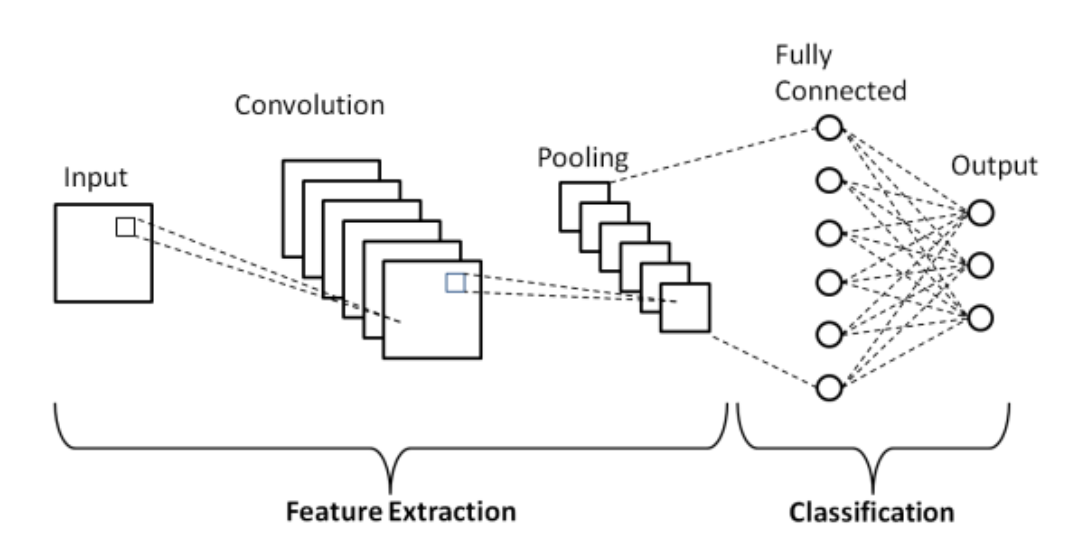 

### Table of Contents
1. Choose the best CNN architecture
2. Build the model with best CNN architecture


### How to choose the best CNN architecture?
1. Selection of Conv2D subsampling layers
2. Selection of Conv2D feature maps
3. Selection of Conv2D Dense layer
4. Selection of Conv2D Dropput layer

In [1]:
# import necessary libraries

import numpy as np
import keras

# MNIST dataset
from keras.datasets import mnist

# to build the model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# 
from matplotlib import pyplot as plt

# (train,test) data split
from sklearn.model_selection import train_test_split

# to calculate accuracy
import sklearn.metrics as metrics

# learning rate
from keras.callbacks import LearningRateScheduler

# to create artifical train images
from keras.preprocessing.image import ImageDataGenerator

# global variables
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)


In [2]:
# Load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# shape of train, test data
print({'train data': X_train.shape, 'test data': X_test.shape})

{'train data': (60000, 28, 28), 'test data': (10000, 28, 28)}


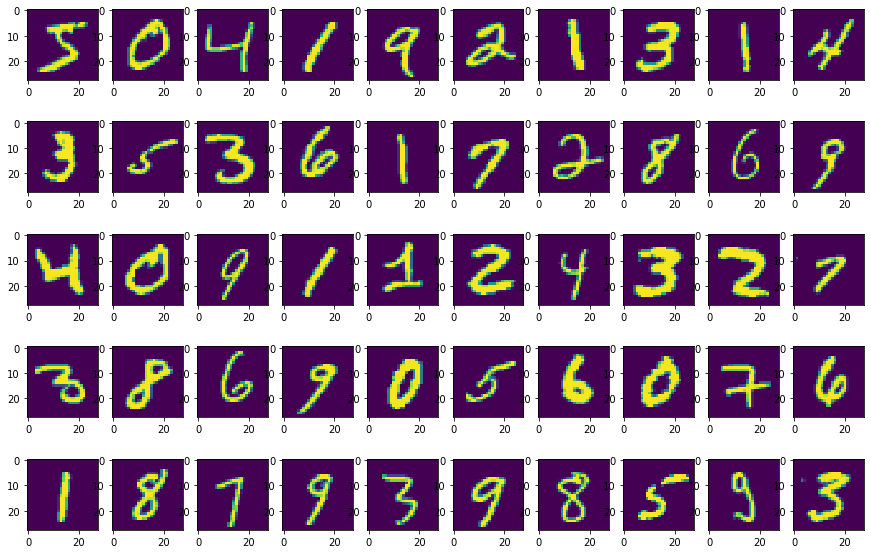

In [4]:
# Images from the train data set
plt.figure(figsize=(15,10))
x, y = 10, 5
for i in range(50):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

In [5]:
# reshape the input image using 'image_data_format()'

print("Image data format:", K.image_data_format())

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test  = X_test.reshape(X_test.shape[0], 28, 28, 1)

print("train:", X_train.shape)
print("test:",  X_test.shape)

Image data format: channels_last
train: (60000, 28, 28, 1)
test: (10000, 28, 28, 1)


In [6]:
# check the output of output variable 'Y'
print('train_output:', y_train)
print('test_output:', y_test)

train_output: [5 0 4 ... 5 6 8]
test_output: [7 2 1 ... 4 5 6]


In [7]:
# Change the format of output 'Y' using 'keras.utils.to_categorical'

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# print('train_output:', y_train)
# print('test_output:', y_test)

## <center>Lets start with "finding the best CNN architecture"<center>
 

## Selection of Conv2D subsampling layers

  **Considering the image size (28 * 28), we can go for 3 subsampling layers, further layers will make the size of the image very less.**

1. after one layer image size becomes (14 * 14), 
2. after second layer image size becomes (7 * 7), 
3. after third layer image size becomes either (3 * 3) or (4 * 4). 

In [8]:
model = [0,0,0]

for i in range(3):
    
    model[i] = Sequential()    
    model[i].add(Conv2D(32, kernel_size = 5, padding='same', activation = 'relu', input_shape = (28,28,1)))
    model[i].add(MaxPooling2D())

    if i>0:
        model[i].add(Conv2D(48, kernel_size = 5, padding='same', activation = 'relu', input_shape = (28,28,1)))
        model[i].add(MaxPooling2D())    

    if i>1:
        model[i].add(Conv2D(64, kernel_size = 5, padding='same', activation = 'relu', input_shape = (28,28,1)))
        model[i].add(MaxPooling2D(padding='same'))
        
# Now flatten the model and compile 

    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
# to display the summary of models use "model[i].summary()""

model[2].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 48)        38448     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          76864     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)             

In [10]:
# Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.3)

# fit the model
history = [0] * 3
names = ["1layer","2layers","3layers"]
epochs = 20
for j in range(3):
    history[j] = model[j].fit(X_train1,y_train1, callbacks=[annealer], batch_size=100, epochs = epochs, validation_data = (X_test1,y_test1), verbose=0)        
    print("Conv2D {0}: Epochs={1:d}, train accuracy={2:.5f}, test accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Conv2D 1layer: Epochs=20, train accuracy=0.99921, test accuracy=0.98367
Conv2D 2layers: Epochs=20, train accuracy=0.99952, test accuracy=0.98911
Conv2D 3layers: Epochs=20, train accuracy=0.99862, test accuracy=0.99111


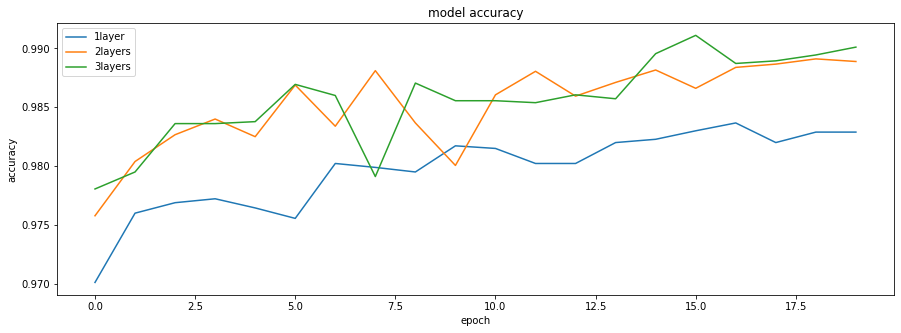

In [11]:
# Display the test accuracy against epoch 
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(history[i].history['val_accuracy'])  
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')

### Conclusion: 
> We can go either with 2 layers or 3 layers. lets go with 2 layers in final model

# Selection of feature maps

#### lets test for below feature maps 
>  (8,16), (16,32), (32,64) and (64, 128)

In [12]:
model = [0,0,0,0]

for i in range(4):
    
    model[i] = Sequential()
    model[i].add(Conv2D((8*2**i), kernel_size = 5, activation = 'relu', input_shape = (28,28,1)))
    model[i].add(MaxPooling2D())

    model[i].add(Conv2D((16*2**i), kernel_size = 5, activation = 'relu', input_shape = (28,28,1)))
    model[i].add(MaxPooling2D())

# Now flatten the model and compile 

    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
# to display the summary of models use "model[i].summary()""

model[2].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [14]:
# Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.3)

# fit the model
history = [0] * 4
names = ["(8,16) maps","(16,32) maps","(32,64) maps", "(64,128) maps"]
epochs = 20
for j in range(4):
    history[j] = model[j].fit(X_train1,y_train1, callbacks=[annealer], batch_size=100, epochs = epochs, validation_data = (X_test1,y_test1), verbose=0)        
    print("Conv2D {0}: Epochs={1:d}, train accuracy={2:.5f}, test accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Conv2D (8,16) maps: Epochs=20, train accuracy=0.99960, test accuracy=0.98372
Conv2D (16,32) maps: Epochs=20, train accuracy=0.99895, test accuracy=0.98567
Conv2D (32,64) maps: Epochs=20, train accuracy=0.99981, test accuracy=0.98989
Conv2D (64,128) maps: Epochs=20, train accuracy=0.99962, test accuracy=0.98911


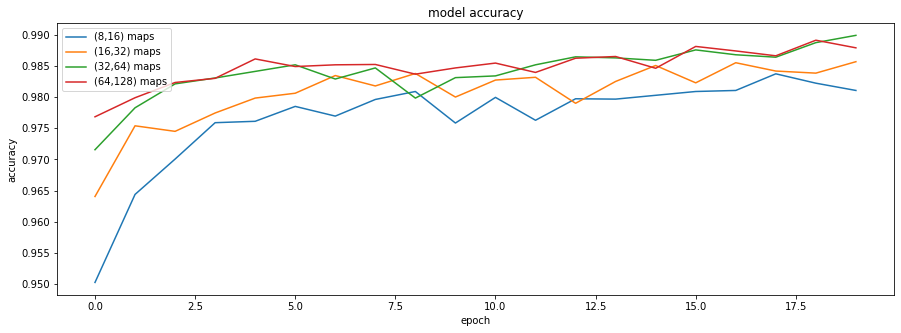

In [15]:
# Display the test accuracy against epoch 
plt.figure(figsize=(15,5))
for i in range(4):
    plt.plot(history[i].history['val_accuracy'])  
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')

### Conclusion
> (32,64) and (64,128) maps gives better train/test accuracy  

> Lets go with 32 maps in layer1 and 64 maps in layer2 in final model

# Selection of Dense layer

> lets try with (32, 64, 128, 256, 512) dense layers

In [16]:
model = [0]*5

for i in range(5):

    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size = 5, activation = 'relu', input_shape = (28,28,1)))
    model[i].add(MaxPooling2D())

    model[i].add(Conv2D(64, kernel_size = 5, activation = 'relu', input_shape = (28,28,1)))
    model[i].add(MaxPooling2D())
    model[i].add(Flatten())

  # Now iterate over Dense layer
    if i >= 0:
        model[i].add(Dense(32*2**i, activation='relu'))

    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# to display the summary of models use "model[i].summary()""

model[4].summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_23 (Dense)             (None, 10)              

In [18]:
# Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.3)

# fit the model
history = [0] * 5
names = ["32 inputs","64 inputs","128 inputs", "256 inputs", "512 inputs"]
epochs = 20
for j in range(5):
    history[j] = model[j].fit(X_train1,y_train1, callbacks=[annealer], batch_size=100, epochs = epochs, validation_data = (X_test1,y_test1), verbose=0)        
    print("Conv2D {0}: Epochs={1:d}, train accuracy={2:.5f}, test accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Conv2D 32 inputs: Epochs=20, train accuracy=0.99902, test accuracy=0.98644
Conv2D 64 inputs: Epochs=20, train accuracy=0.99921, test accuracy=0.98694
Conv2D 128 inputs: Epochs=20, train accuracy=0.99957, test accuracy=0.98822
Conv2D 256 inputs: Epochs=20, train accuracy=0.99931, test accuracy=0.98883
Conv2D 512 inputs: Epochs=20, train accuracy=0.99912, test accuracy=0.98794


### Conclusion:
>  dense layer with 128 inputs gives better test accuracy

# Selection of %Drop out

In [19]:
model = [0]*5

for i in range(5):
    
    model[i] = Sequential()
    model[i].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[i].add(MaxPooling2D())
    model[i].add(Dropout(i*0.1))
    model[i].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[i].add(MaxPooling2D())
    model[i].add(Dropout(i*0.1))
    model[i].add(Flatten())
    model[i].add(Dense(128, activation='relu'))
    model[i].add(Dropout(i*0.1))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
# Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.3)

# fit the model
history = [0] * 5
names = ["0% drop","10% drop","20% drop", "30% drop", "40% drop"]
epochs = 20
for j in range(5):
    history[j] = model[j].fit(X_train1,y_train1, callbacks=[annealer], batch_size=100, epochs = epochs, validation_data = (X_test1,y_test1), verbose=0)        
    print("Conv2D {0}: Epochs={1:d}, train accuracy={2:.5f}, test accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Conv2D 0% drop: Epochs=20, train accuracy=0.99924, test accuracy=0.98694
Conv2D 10% drop: Epochs=20, train accuracy=0.99667, test accuracy=0.99039
Conv2D 20% drop: Epochs=20, train accuracy=0.99293, test accuracy=0.99128
Conv2D 30% drop: Epochs=20, train accuracy=0.98836, test accuracy=0.99117
Conv2D 40% drop: Epochs=20, train accuracy=0.98312, test accuracy=0.99083


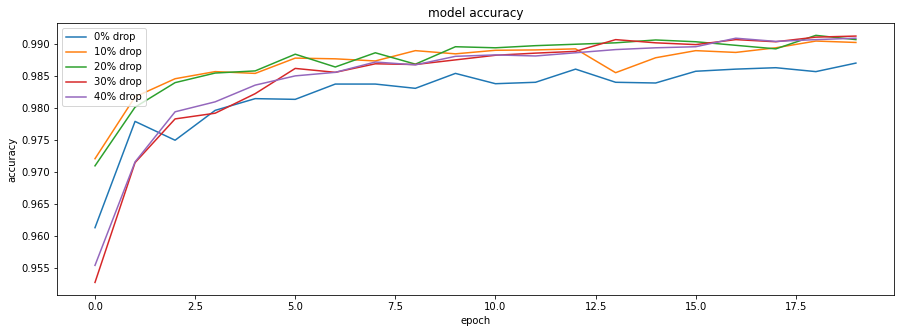

In [21]:
# Display the test accuracy against epoch 
plt.figure(figsize=(15,5))
for i in range(5):
    plt.plot(history[i].history['val_accuracy'])  
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')

### Conclusion:
> 30% dropout gives better test accuracy

## Final model combination
> two Conv2D subsampling, (32,64) feature maps, 128 inputs, 30% dropout

In [22]:
# Build the final model

model = Sequential()
model.add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(64,kernel_size=5,activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1024)            

In [24]:
model.fit(X_train, y_train, batch_size = 100,
          epochs = 20, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/20
600/600 [==============================] - 2s 4ms/step - loss: 0.9754 - accuracy: 0.8229 - val_loss: 0.0754 - val_accuracy: 0.9777
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1720 - accuracy: 0.9489 - val_loss: 0.0500 - val_accuracy: 0.9841
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1248 - accuracy: 0.9633 - val_loss: 0.0400 - val_accuracy: 0.9872
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1051 - accuracy: 0.9699 - val_loss: 0.0428 - val_accuracy: 0.9875
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0919 - accuracy: 0.9737 - val_loss: 0.0325 - val_accuracy: 0.9893
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0861 - accuracy: 0.9746 - val_loss: 0.0260 - val_accuracy: 0.9909
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0822 - accuracy: 0.9759 - val_loss: 0.0295 - val_accuracy: 0.9908
Epoch 

In [25]:
# Predict 'X_test'
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Convert categorical values of y_test
y_actual = np.argmax(y_test, axis=1)

# Accuracy of test data
print('Accuracy:', metrics.accuracy_score(y_actual,y_test_pred))

Accuracy: 0.9897


## Additional ways to improve accuracy
1. test the model with two (3 * 3) kernal_size instead of (5 * 5)
2. test the model with strides = 2 instead of maxpooling 
3. test the model with batch normalization
4. test the model with Data Augmentation

### Test the model by replacing kernel size = 5 with two kernel size = 3

In [26]:
# Lets add 3*3 kernel_size instead of 5*5
model = Sequential()

# Start - Add two 3*3 kernel_size
model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(32,kernel_size=3,activation='relu'))
# End - Add two 3*3 kernel_size

model.add(MaxPooling2D())
model.add(Dropout(0.3))

# Start - Add two 3*3 kernel_size
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
# End - Add two 3*3 kernel_size

model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 4, 4, 64)        

In [28]:
model.fit(X_train, y_train, batch_size = 100,
          epochs = 20, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.6483 - accuracy: 0.8559 - val_loss: 0.0590 - val_accuracy: 0.9806
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1165 - accuracy: 0.9656 - val_loss: 0.0337 - val_accuracy: 0.9880
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0793 - accuracy: 0.9762 - val_loss: 0.0316 - val_accuracy: 0.9889
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0687 - accuracy: 0.9794 - val_loss: 0.0270 - val_accuracy: 0.9903
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0600 - accuracy: 0.9818 - val_loss: 0.0273 - val_accuracy: 0.9902
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0562 - accuracy: 0.9837 - val_loss: 0.0225 - val_accuracy: 0.9922
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0498 - accuracy: 0.9850 - val_loss: 0.0210 - val_accuracy: 0.9929
Epoch 

In [29]:
# Predict 'X_test'
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Convert categorical values of y_test
y_actual = np.argmax(y_test, axis=1)

# Accuracy of test data
print('Accuracy:', metrics.accuracy_score(y_actual,y_test_pred))

Accuracy: 0.9942


### Test the model with strides = 2 instead of Maxpooling (2,2)

In [30]:
model = Sequential()

model.add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(32,kernel_size=5, strides = 2, padding = 'same', activation='relu'))

#model.add(MaxPooling2D())
model.add(Dropout(0.3))

 
model.add(Conv2D(64,kernel_size=5,activation='relu'))
model.add(Conv2D(64,kernel_size=5, strides = 2, padding = 'same', activation='relu'))
 
#model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
dropout_21 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 4, 4, 64)          102464    
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1024)            

In [32]:
model.fit(X_train, y_train, batch_size = 100,
          epochs = 20, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/20
600/600 [==============================] - 3s 6ms/step - loss: 0.3714 - accuracy: 0.8903 - val_loss: 0.0514 - val_accuracy: 0.9835
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0912 - accuracy: 0.9736 - val_loss: 0.0340 - val_accuracy: 0.9899
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0664 - accuracy: 0.9804 - val_loss: 0.0334 - val_accuracy: 0.9883
Epoch 4/20
600/600 [==============================] - 3s 6ms/step - loss: 0.0558 - accuracy: 0.9841 - val_loss: 0.0320 - val_accuracy: 0.9909
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0527 - accuracy: 0.9845 - val_loss: 0.0288 - val_accuracy: 0.9914
Epoch 6/20
600/600 [==============================] - 3s 6ms/step - loss: 0.0507 - accuracy: 0.9856 - val_loss: 0.0378 - val_accuracy: 0.9892
Epoch 7/20
600/600 [==============================] - 3s 6ms/step - loss: 0.0494 - accuracy: 0.9865 - val_loss: 0.0269 - val_accuracy: 0.9913
Epoch 

In [33]:
# Predict 'X_test'
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Convert categorical values of y_test
y_actual = np.argmax(y_test, axis=1)

# Accuracy of test data
print('Accuracy:', metrics.accuracy_score(y_actual,y_test_pred))

Accuracy: 0.9916


#### We can add 'Batch normalization' to the above models and check for test accuracy

### Test the model with 'Data Augmentation'

> please go through below link for understanding 'Data augmentation'

> https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [34]:
# Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalize. 

image_data_gen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)


In [35]:
# Basic Model

model = Sequential()
model.add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(64,kernel_size=5,activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [36]:
# Currently i'm using 'above model' for 'Data Augmentation'

model.fit_generator(image_data_gen.flow(X_train,y_train, batch_size = 100), epochs = 50, 
    steps_per_epoch = X_train.shape[0]//100, callbacks=[annealer], verbose=0)


In [37]:
X_train.shape

(60000, 28, 28, 1)

#### With 'Data augmentation' more train images are generated by (rotation, shifting, ..)
### For each epoch, 60K different images are generated, so model is trained with (60k * 50) = 3 million images

In [38]:
# Predict 'X_test'
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

# Convert categorical values of y_test
y_actual = np.argmax(y_test, axis=1)

# Accuracy of test data
print('Accuracy:', metrics.accuracy_score(y_actual,y_test_pred))

Accuracy: 0.9942


## Conclusion:
1. ### For each 'combination change' in the basic model, there is an improvement in test accuracy
2. ### Similarly, we can use all combinations in a single model and improve the test accuracy.
# And this notebook is inspired from the works of Kaggle grandmaster ('Chris Deotte')
